In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import sys
import re, string
import nltk, spacy, gensim
from scipy.stats.mstats import gmean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, fbeta_score 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion, Pipeline 


from numpy import dot
from numpy.linalg import norm
import pickle

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_data(data_splits):
    """
    Function that combines the DataFrame for training, validation, and test.
    """
    path = "dataset/archive/disaster_response_messages_{}.csv"
    dfs = []
    for data_split in data_splits:
        file_path = path.format(data_split)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs) #combine files for each split

In [4]:
def data_cleaning(data_df):
    """
    Function that cleans the data.
    """    
    data_df = data_df.drop_duplicates()
    return data_df 

In [5]:
def save_to_database(data_df,db_name):
    """
    Save data to database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Write dataframe to database
    data_df.to_sql('data_df',engine,if_exists='replace')
    pass 

In [6]:
def load_from_database(db_name):
    """
    Load data from database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Read dataframe from database
    data_df = pd.read_sql_table('data_df',engine)
    data_df = data_df.dropna(subset=["message"])
    X = data_df['message'].fillna(value='')
    C = data_df.iloc[:,4:]
    message_class = C.columns
    return X, C, message_class

In [7]:
def document_cleaning(data_df):
    """
    Function that cleans the document.
    """    

    data = data_df.values.tolist()                            # convert data to list
    data = [re.sub(r'\S*@\S*\s?', '', item) for item in data] # Remove email addresses
    data = [re.sub('[%s]' % re.escape(string.punctuation), ' ', item) for item in data] # Remove punctuations
    data = [re.sub(r'\s+', ' ', item) for item in data]       # Remove characters that begin a new line
    data = [re.sub(r"\'", "", item) for item in data]         # Remove single quotes
    data = [re.sub(r'\w*\d\w*', ' ', item) for item in data]  # Remove numbers
    data = [re.sub(r' +', ' ', item) for item in data]# Remove extra spaces
    data = [item.lower() for item in data]                    # Make each document lower case
    
    return data

In [8]:
def tokenize_doc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

### Load data from database

In [10]:
# Load data from database

database_name = 'disaster_response.db'
X, C, message_class = load_from_database(database_name)

# train test split
#X_train, X_test, y_train, y_test = train_test_split(X, C,test_size=.2, random_state=2018)

In [11]:
pprint(X[:1])

0    Weather update - a cold front from Cuba that c...
Name: message, dtype: object


In [12]:
pprint(message_class)

Index(['genre', 'related', 'PII', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


### Document Cleaning

In [13]:
# Document cleaning

# X = X[:100]
message_data = document_cleaning(X)
pprint(message_data[:1])

['weather update a cold front from cuba that could pass over haiti']


### Tokenize documents

In [14]:
message_words = list(tokenize_doc(message_data))
print(message_words[:2])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over']]


In [15]:
# Initialize spaCy ‘en_core_web_sm’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [52]:
def topic_prediction(text, nlp=nlp):
    global tokenize_doc
    global lemmatization
    text_doc2 = list(tokenize_doc(text))
    text_doc3 = lemmatization(text_doc2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    text_doc4 = vectorizer.transform(text_doc3)
    topic_probability_scores = model.transform(text_doc4)
    topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    infer_topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), -1]
    return infer_topic, topic, topic_probability_scores

In [17]:
def similar_corpus(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    dist = euclidean_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(dist)
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [18]:
def similar_corpus_cosine(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    #dist = cosine_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    dist = cosine_similarity(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(np.argsort(dist))
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [19]:
# Lemmatization for any choice to keep -  Noun, Adj, Verb, Adverb ['NOUN', 'ADJ', 'VERB', 'ADV']

message_lemmatized = lemmatization(message_words, allowed_postags=['NOUN', 'VERB'])

In [20]:
print(message_lemmatized[:3])

['weather update front pass', 'be hurricane be', 'look name']


In [22]:
print(message_words[:4])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'], ['looking', 'for', 'someone', 'but', 'no', 'name'], ['un', 'reports', 'leogane', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supplies', 'desperately']]


In [23]:
print(message_lemmatized[:4])

['weather update front pass', 'be hurricane be', 'look name', 'report leogane destroy hospital functioning need supply']


In [24]:
# Document word Matrix
# Document word Matrix
# Words that have occured in less than 10 documents (min_df) are cut off
# Words that have occured in more than 50% of the documents (max_df, None) are cut off
# At least 3 characters in each word
# Max number of unique words = 50000

vectorizer = CountVectorizer(analyzer='word',min_df=10,max_df=0.5,stop_words='english',lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',max_features=50000)
message_vectorized = vectorizer.fit_transform(message_lemmatized)

In [74]:
# LSA Model

model = TruncatedSVD(n_components=10,algorithm='randomized',n_iter=10,random_state=100,tol=0.0)
output = model.fit_transform(message_vectorized)
print(model)  # Model attributes

TruncatedSVD(n_components=10, n_iter=10, random_state=100)


In [28]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [29]:
# Dominant topics (Create Document — Topic Matrix)

topic_names = ["Topic" + str(i) for i in range(model.n_components)] # column names
doc_names = ["Doc" + str(i) for i in range(len(message_data))]               # index names
# Document — Topic Matrix dataframe
document_topic_df = pd.DataFrame(np.round(output, 2), columns=topic_names, index=doc_names)
# Get dominant topic for each document
dominant_topics = np.argmax(document_topic_df.values, axis=1)
document_topic_df["dominant_topic"] = dominant_topics

document_topics_df = document_topic_df.head(15)
document_topics_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.06,0.06,0.05,0.01,0.03,0.05,-0.00,0.07,0.02,0.03,7
Doc1,0.01,0.00,0.01,0.00,0.01,0.02,0.01,0.00,0.01,0.02,5
Doc2,0.01,-0.00,0.01,-0.00,0.00,-0.00,0.01,-0.01,0.01,0.01,0
Doc3,0.42,-0.46,0.14,0.06,0.14,0.51,-0.47,-0.30,-0.09,-0.19,5
Doc4,0.34,0.24,0.10,-0.07,0.29,-0.10,-0.13,-0.22,0.79,-0.05,8
Doc5,0.02,-0.02,0.04,-0.03,0.03,0.10,0.06,-0.12,0.02,0.26,9
Doc6,0.06,0.06,0.04,0.01,0.02,0.03,-0.01,0.06,0.02,0.03,0
Doc7,0.67,-0.86,-0.41,-0.18,-0.27,0.85,-0.39,-0.13,0.12,0.24,5
Doc8,0.10,-0.15,0.16,-0.09,0.02,0.03,0.11,-0.23,0.10,0.95,9
Doc9,0.31,0.12,-0.08,-0.08,0.18,-0.10,-0.15,-0.19,-0.64,-0.00,0


In [30]:
# Topic-Keyword Matrix

topic_keywords_df = pd.DataFrame(model.components_)
# Assign Column and Index
topic_keywords_df.columns = vectorizer.get_feature_names()
topic_keywords_df.index = topic_names
# View
topic_keywords_df.head()

,abandon,ability,absence,absorb,abuse,accelerate,accept,access,accident,accommodate,...,yard,year,yesterday,yield,yorker,youth,yuan,zimbabwe,zinc,zone
Topic0,0.003675,0.002354,0.003156,0.001374,0.000844,0.001167,0.003339,0.021129,0.003869,0.000800,...,0.000794,0.088705,0.005900,0.006374,0.000212,0.001686,0.002912,0.004156,0.000745,0.011161
Topic1,0.000958,0.001060,0.002294,0.001186,0.000293,0.000106,0.000790,0.000308,0.003903,0.000603,...,-0.001590,0.057201,0.000606,0.004405,-0.000088,-0.000664,0.002651,0.000262,0.000347,-0.001731
Topic2,-0.000746,0.000709,-0.000524,-0.000112,-0.000059,-0.000758,-0.000894,-0.015326,0.001290,0.000875,...,0.001797,0.019220,-0.000022,-0.002628,0.000181,0.000585,0.000480,-0.003349,0.000037,0.001589
Topic3,-0.002426,-0.000673,0.000963,-0.001160,-0.000643,0.000675,-0.001192,-0.006956,-0.000490,0.000309,...,-0.000278,-0.016427,-0.004101,-0.000977,0.000409,-0.001434,-0.000123,-0.001785,-0.000463,0.001744
Topic4,-0.000278,0.003076,0.003449,0.000038,0.001583,0.001446,0.002776,0.002488,0.002547,0.000114,...,-0.001229,0.094174,0.003586,0.008640,0.000566,0.001315,0.002567,0.003228,-0.000175,-0.001031


In [37]:
# Keyword-topic Matrix for top n words

keyword_topic_df = pd.DataFrame(model.components_).T
# Assign Column and Index
keyword_topic_df.index = vectorizer.get_feature_names()
keyword_topic_df.columns = topic_names
# View
keyword_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
abandon,0.003675,0.000958,-0.000746,-0.002426,-0.000278,-0.000931,-0.002362,0.000275,0.002187,0.001234
ability,0.002354,0.001060,0.000709,-0.000673,0.003076,-0.001533,-0.000182,-0.002214,0.003565,-0.001049
absence,0.003156,0.002294,-0.000524,0.000963,0.003449,-0.000005,0.000131,0.002907,-0.002518,0.001747
absorb,0.001374,0.001186,-0.000112,-0.001160,0.000038,0.002035,-0.000416,0.003005,0.001443,0.000005
abuse,0.000844,0.000293,-0.000059,-0.000643,0.001583,-0.001480,-0.000708,-0.003159,0.001379,-0.000258


In [38]:
# Show top n keywords for each topic

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=model, n_words=15)

# Topic - Keywords Dataframe
topic_keywords_df = pd.DataFrame(topic_keywords)
topic_keywords_df.columns = ['Word '+str(i) for i in range(topic_keywords_df.shape[1])]
topic_keywords_df.index = ['Topic '+str(i) for i in range(topic_keywords_df.shape[0])]

#Keywords-topic
keywords_topic_df = pd.DataFrame(topic_keywords).T
keywords_topic_df.columns = ['Topic '+str(i) for i in range(keywords_topic_df.shape[1])]
keywords_topic_df.index = ['Word '+str(i) for i in range(keywords_topic_df.shape[0])]

keywords_topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,water,people,help,food,food,need,earthquake,rain,say,know
Word 1,people,say,people,people,say,earthquake,food,help,water,like
Word 2,food,rain,need,need,rain,water,http,flood,know,thank
Word 3,say,flood,earthquake,tent,earthquake,rain,bit,water,official,information
Word 4,area,area,rain,cook,area,http,water,food,food,want
Word 5,need,cause,thank,kill,country,information,help,cause,country,rain
Word 6,help,earthquake,kill,distribution,flood,bit,like,rainfall,thank,country
Word 7,flood,region,know,item,government,flood,haiti,monsoon,like,send
Word 8,rain,affect,say,eat,year,cause,know,flooding,day,message
Word 9,country,kill,flood,clothing,relief,monsoon,com,kill,make,school


In [39]:
# Message-Topic-Matrix
document_topic_df['message'] = message_data
document_topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,message
Doc0,0.06,0.06,0.05,0.01,0.03,0.05,-0.00,0.07,0.02,0.03,7,weather update a cold front from cuba that cou...
Doc1,0.01,0.00,0.01,0.00,0.01,0.02,0.01,0.00,0.01,0.02,5,is the hurricane over or is it not over
Doc2,0.01,-0.00,0.01,-0.00,0.00,-0.00,0.01,-0.01,0.01,0.01,0,looking for someone but no name
Doc3,0.42,-0.46,0.14,0.06,0.14,0.51,-0.47,-0.30,-0.09,-0.19,5,un reports leogane destroyed only hospital st ...
Doc4,0.34,0.24,0.10,-0.07,0.29,-0.10,-0.13,-0.22,0.79,-0.05,8,says west side of haiti rest of the country to...
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc26211,0.17,0.02,-0.08,-0.03,0.09,-0.11,-0.02,-0.13,-0.01,-0.03,0,the training demonstrated how to enhance micro...
Doc26212,0.15,0.02,-0.01,-0.05,0.09,-0.09,-0.03,-0.20,-0.07,0.07,0,a suitable candidate has been selected and och...
Doc26213,0.11,-0.00,0.01,-0.02,0.06,-0.05,-0.01,-0.09,-0.04,-0.01,0,proshika operating in cox s bazar municipality...
Doc26214,0.13,0.01,0.01,-0.02,0.05,-0.06,0.00,-0.14,0.02,0.03,0,some women protesting against the conduct of t...


## Topic interpretation

* ### Topic0

In [40]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic0', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic1

In [41]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic1', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic2

In [42]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic2', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic3

In [43]:
# Topic interpretation
# interpreted as: HYGIENE/AID/AID_UPDATE-FOOD,MEDICINE

tmp_df = document_topic_df.sort_values('Topic3', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

observe strict hygienic practice namely wash hands every time before eating and during food preparation clean and disinfect every surfaces and utensils used for cooking store cooked food separate from fresh food cooking the food thoroughly and store cooked food in appropriate temperature do not left cooked food in the room temperature more than hours keep cooked and perishable food in the refrigerator ° c and reheat cooked food before eating °c 

those are choose cooked food which had been prepared by food safety process cook food thoroughly eat just cooked food keep cooked food carefully reheat cooked food before consumption separate raw food from cooked food wash hands frequently clean and keep kitchen utensils in close place out of reach from flies rodents or other animals and use clean water 

we are rescue ministries church a soup kitchen and food pantry located at richmond terrace we will be bring hot meals to hurricane site to feed the need we need all paper products and foil tr

* ### Topic4

In [44]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic4', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

since november there has been mm of rainfall and cyclonic winds up to hr in the jaffna peninsula causing widespread flooding typhoon parma packing gusts of kilometres miles an hour was forecast to hit rural areas in the north of the philippines main island of luzon before dawn on saturday output was reduced as a result of a shortage of irrigation water following a mild winter and poor management of water resources with catastrophic impacts on agriculture in the down river regions of the amudarya the autonomous region of karakalpakstan and khorizem but particularly the former on april a second eruption occurred resulting in a volcanic mudflow also referred to as a lahar therefore we request all our supporters and friends to please consider donating for these emergency food relief aids for flood victims may a magnitude earthquake struck in the afternoon during our aid distribution and multiple strong aftershocks followed the swiss ministry for defence civil protection and sports is also 

* ### Topic5

In [45]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic5', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic6

In [46]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic6', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

earthquake pictures earthquake photo earthquake images haiti country haiti country earthquake haiti country earthquake pictures

yangon may irin the recent quake that shook myanmar s northeastern shan state killing and affecting http www themimu info earthquake shan earthquake reports ocha sit rep myanmar earthquake pdf http www themimu info earthquake shan earthquake reports ocha sit rep myanmar earthquake pdf serves as a stark warning for this largely unprepared earthquake prone country say experts 

musings haiti earthquake haiti haiti news haiti earthquakes haiti earthquake haiti haiti news haiti http bit ly 

the sea level increased overnight and in some areas the situation has been adversely affected by the blocking of drainage canals the hospital includes a patient ward operating theater emergency treatment room laboratory dispensary radiology unit and a gynecology obstetrics ward mali one of africa s poorest nations faces a series of arduous tasks including restoring stability 

* ### Topic7

In [47]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic7', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic8

In [48]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic8', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the weather forecast indicates that rains should go on until at least late december the severe drought parching east africa has left million facing hunger and the scope of one of the world s worst unfolding humanitarian disasters conjured up memories of ethiopia s devastating famine seismologists agree that padang will face more earthquakes in future and warn that a much larger quake with far greater destructive force is inevitable in the region the flash floods that followed torrential monsoonal rains in north west pakistan between and july have caused great loss of life and wide spread damage to infrastructure livestock and property in more than villages lesotho and swaziland would also experience scattered rains he noted but while floodwaters have subsided in some areas there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere approximately million people have been affected in the past week by heavy torrential monsoon rains which flooded bloc

* ### Topic9

In [49]:
# Topic interpretation
# interpreted as: 

tmp_df = document_topic_df.sort_values('Topic9', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i would like to know when the opening of the school because i would like to know of informations relating to it 

since november there has been mm of rainfall and cyclonic winds up to hr in the jaffna peninsula causing widespread flooding typhoon parma packing gusts of kilometres miles an hour was forecast to hit rural areas in the north of the philippines main island of luzon before dawn on saturday output was reduced as a result of a shortage of irrigation water following a mild winter and poor management of water resources with catastrophic impacts on agriculture in the down river regions of the amudarya the autonomous region of karakalpakstan and khorizem but particularly the former on april a second eruption occurred resulting in a volcanic mudflow also referred to as a lahar therefore we request all our supporters and friends to please consider donating for these emergency food relief aids for flood victims may a magnitude earthquake struck in the afternoon during our aid distrib

In [50]:
# Put inferred topics into dataframe

Topics = ["Topic 0","Topic 1","Topic 2",\
           "HYGIENE/AID/AID_UPDATE-FOOD,MEDICINE","Topic 4","Topic 5",\
           "Topic 6","Topic 7","Topic 8",\
           "Topic 9"]
topic_keywords_df["Topics"]=Topics
topic_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,water,people,food,say,area,need,help,flood,rain,country,provide,government,include,earthquake,supply,Topic 0
Topic 1,people,say,rain,flood,area,cause,earthquake,region,affect,kill,rainfall,monsoon,flooding,hit,report,Topic 1
Topic 2,help,people,need,earthquake,rain,thank,kill,know,say,flood,like,house,come,cause,monsoon,Topic 2
Topic 3,food,people,need,tent,cook,kill,distribution,item,eat,clothing,baby,wfp,product,aid,medicine,"HYGIENE/AID/AID_UPDATE-FOOD,MEDICINE"
Topic 4,food,say,rain,earthquake,area,country,flood,government,year,relief,region,cause,crop,child,disaster,Topic 4
Topic 5,need,earthquake,water,rain,http,information,bit,flood,cause,monsoon,rainfall,hit,haiti,know,weather,Topic 5
Topic 6,earthquake,food,http,bit,water,help,like,haiti,know,com,information,hit,news,victim,magnitude,Topic 6
Topic 7,rain,help,flood,water,food,cause,rainfall,monsoon,flooding,kill,weather,region,wind,crop,river,Topic 7
Topic 8,say,water,know,official,food,country,thank,like,day,make,kill,want,government,force,school,Topic 8
Topic 9,know,like,thank,information,want,rain,country,send,message,school,make,cause,flood,let,come,Topic 9


### Topic Prediction

In [53]:
# Predict the topic
text_doc = ["Can we get some food"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)

['people', 'need', 'tent', 'cook', 'kill', 'distribution', 'item', 'eat', 'clothing', 'baby', 'wfp', 'product', 'aid']
HYGIENE/AID/AID_UPDATE-FOOD,MEDICINE


### Cluster Documents within the same topic

In [56]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics
k = 10
kmeans       = KMeans(n_clusters=k, random_state=100)
kmeans_clust = kmeans.fit_predict(output)

# Build SVD model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_svd = svd_model.fit_transform(output)

# plot axes using SVD decomposition
x_val = lda_svd[:, 0]
y_val = lda_svd[:, 1]

Text(0.5, 1.0, 'Topic Clusters')

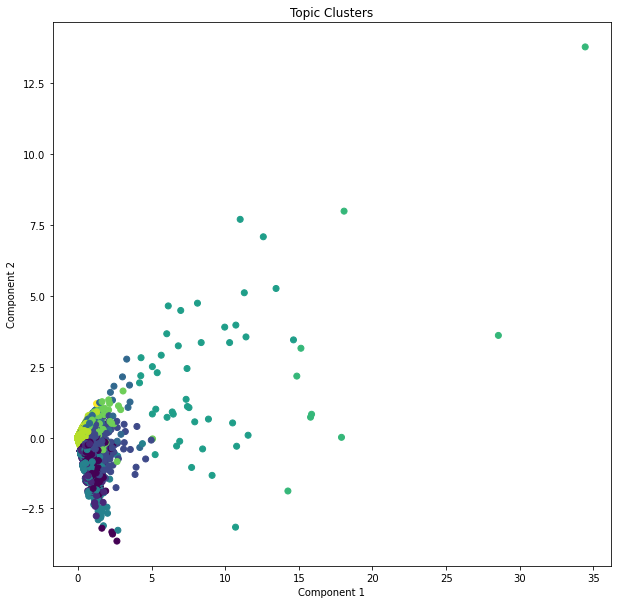

In [57]:
# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")

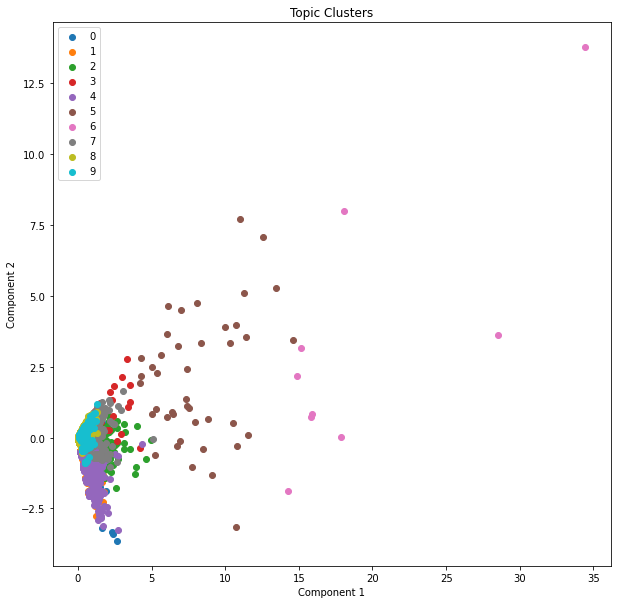

In [59]:
# Plot the cluster of points by topics

k_clusters = np.unique(kmeans_clust)
plt.figure(figsize=(10, 10))
for i in k_clusters:
    filtered_label = output[kmeans_clust == i]
    plt.scatter(filtered_label[:,0], filtered_label[:,1], label = i)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.legend();

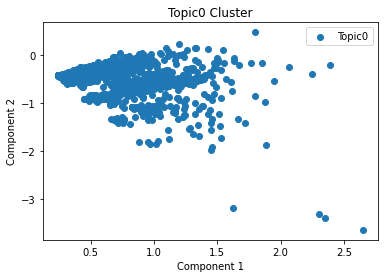

In [60]:
# Topic0 Cluster

filtered_label0 = output[kmeans_clust == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = "Topic0")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic0 Cluster")
plt.legend();

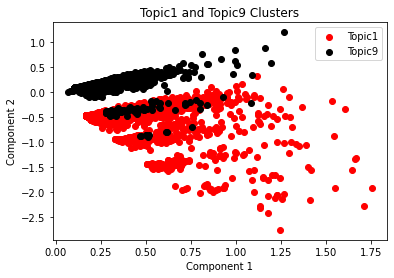

In [61]:
# Topic0 and Topic 1 Clusters
filtered_label1 = output[kmeans_clust == 1]
 
filtered_label9 = output[kmeans_clust == 9]
 
#Plotting the results
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Topic1")
plt.scatter(filtered_label9[:,0] , filtered_label9[:,1] , color = 'black', label = "Topic9")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic1 and Topic9 Clusters")
plt.legend();

### Find documents within a topic that are similar to a given document

In [62]:
# Using Euclidean distance

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
#print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus(text=text_example, doc_topic_probs=output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

HYGIENE/AID/AID_UPDATE-FOOD,MEDICINE

 i don t need food what i need is a tarpaulin for my baby 



### Plots

In [63]:
# Plot distributions
tmp_words = []
for i in range(len(message_words)):
    tmp_words.append(len(message_words[i]))

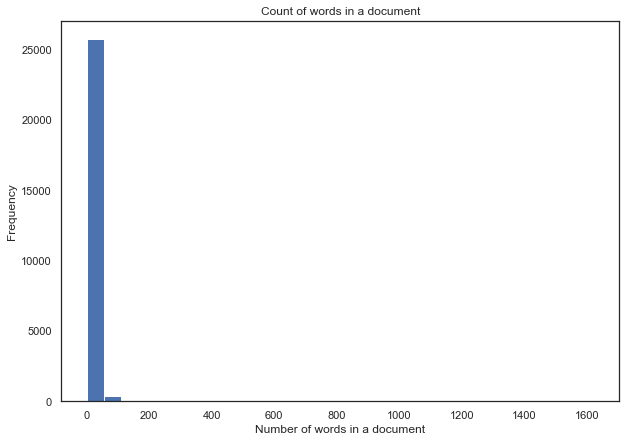

In [64]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(tmp_words,30);
ax.set_title('Count of words in a document')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of words in a document');

In [65]:
# Plots number of documents in topic

topic_list = []
topic_count = []
tot_topic = len(Topics)
for i in range(tot_topic):
    topic_l = Topics[i]
    mask = document_topic_df['dominant_topic'] == i
    topic_c = len(document_topic_df[mask])
    topic_list.append(topic_l)
    topic_count.append(topic_c)

topic_count_dict = {'Topic': topic_list, 'Count': topic_count}
topic_count_df = pd.DataFrame(topic_count_dict)
topic_count_df2 = topic_count_df.sort_values('Count', ascending = False)

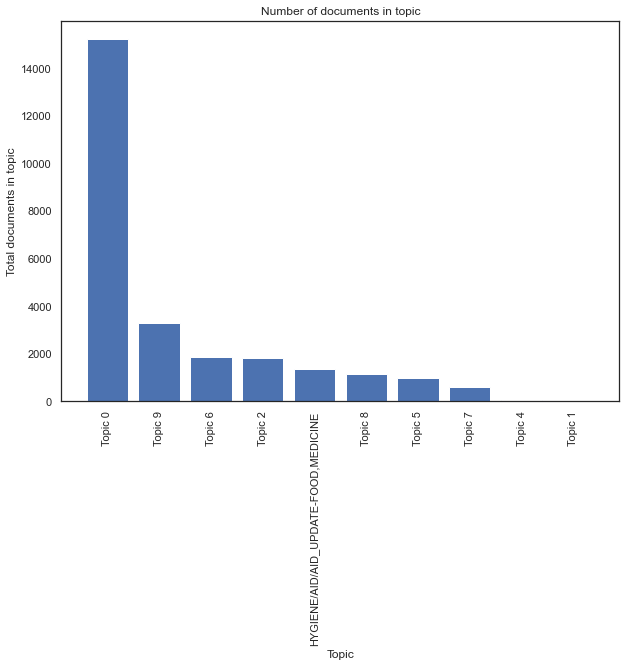

In [66]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
x_index = np.arange(topic_count_df2.Topic.count())
ax.set_xticks(ticks=x_index)

ax.bar(x_index,topic_count_df2['Count']);
ax.set_title('Number of documents in topic')
ax.set_ylabel('Total documents in topic')
ax.set_xlabel('Topic');
ax.set_xticklabels(topic_count_df2['Topic'],rotation = 90, horizontalalignment = 'center' );

### Frequency of keywords in topic

In [67]:
def flatten(outer_list):
    '''
    Function to flatten a list of list
    '''
    return [item for sublist in outer_list for item in sublist]

In [68]:
# top keywords count for Topic 0

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 0
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 0']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

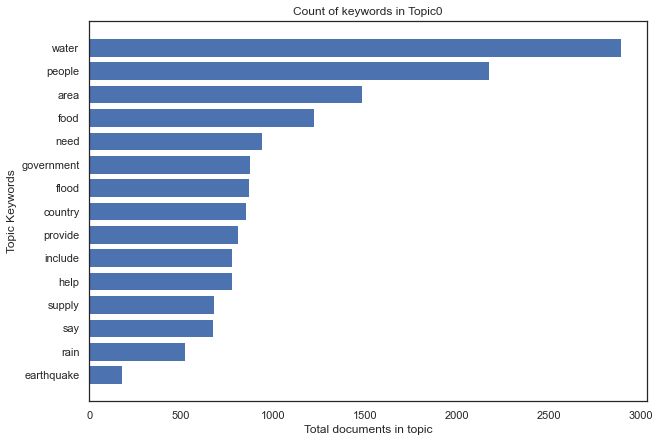

In [69]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic0')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [70]:
# top keywords count for Topic 4

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 4
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 4']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

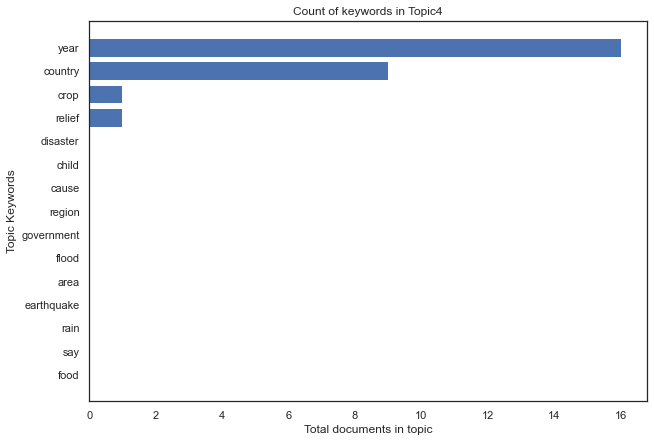

In [71]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic4')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [72]:
# top keywords count for Topic 9

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 9
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 9']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

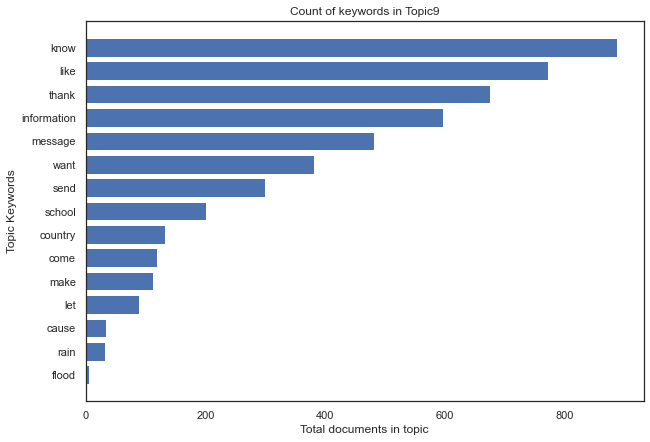

In [73]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic9')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');